In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib inline

In [105]:
def first_integrate(dt, acce, mean):
    """
    Returns a velocity by integrating the acceleration
    """
    v = [0]
    for i in range(1, acce.shape[0]):
        
        a = v[i-1] + (acce[i-1] + acce[i] - 2 * mean)*(dt[i]-dt[i-1])*(1/2)
        v.append(a)
    
    return np.array(v)

In [106]:
def second_integrate(dt, vel):
    """
    Returns position by integrating the velocity
    """
    p = [0,0]
    
    for i in range(2, vel.shape[0]):
        
        a = p[i-1] + (vel[i-1]+vel[i])*(dt[i]-dt[i-1])*(1/2)
        p.append(a)
    
    return np.array(p)

In [107]:
data = pd.read_csv('log7.csv', header=None)
data.columns = 'timestamp acce ax ay az gyro gx gy gz mag mx my mz dt'.split(' ')

acc = 'ax ay az'.split(' ')
vel = 'vx vy vz'.split(' ')
pos = 'px py pz'.split(' ')
dt = np.array(data.timestamp)


calibrate = pd.read_csv('static.csv')
calibrate.columns = 'timestamp acce ax ay az gyro gx gy gz mag mx my mz dt'.split(' ')
error_mean = {
    'ax': float(calibrate.ax.std()),
    'ay': float(calibrate.ay.std()),
    'az': float(calibrate.az.std()),
    'gz': float(calibrate.gz.std())
}

In [108]:
for i in range(0,3):
    
    data[vel[i]] = first_integrate(dt, np.array(data[acc[i]]), error_mean[acc[i]])
    data[pos[i]] = second_integrate(dt, np.array(data[vel[i]]))

data['angle'] = first_integrate(dt, np.array(data['gz']), error_mean['gz'])
data['angle'] = data['angle'].apply(lambda x: math.degrees(x))

In [109]:
data.head()

,timestamp,acce,ax,ay,az,gyro,gx,gy,gz,mag,...,my,mz,dt,vx,px,vy,py,vz,pz,angle
0,682533.15002,3,-0.092,0.032,9.652,4,0.007,0.024,-0.005,5,...,-16.46,15.18,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,682533.16002,3,-0.065,0.017,9.795,4,0.007,-0.001,-0.003,5,...,-16.80,15.10,0.01000,-0.001003,0.000000,0.000188,0.000000,0.096795,0.000000,-0.002997
2,682533.17007,3,-0.083,0.018,9.728,4,0.009,0.010,-0.002,5,...,-16.80,15.10,0.01005,-0.001967,-0.000015,0.000306,0.000002,0.194456,0.001464,-0.005146
3,682533.18001,3,-0.072,0.018,9.759,4,0.008,0.010,-0.003,5,...,-16.60,14.00,0.00994,-0.002954,-0.000039,0.000428,0.000006,0.290869,0.003876,-0.007271
4,682533.19002,3,-0.069,0.026,9.755,4,0.006,0.005,0.001,5,...,-16.60,14.00,0.01001,-0.003878,-0.000074,0.000590,0.000011,0.388096,0.007274,-0.008551


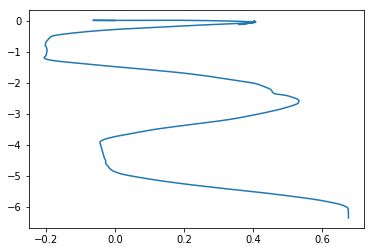

In [110]:
fig = plt.figure()
#ax = Axes3D(fig)
plt.plot(data.px, data.py)

In [111]:
###################################################################################################
#                                                                                                 #
#                                                                                                 #
#      X velocity with gyro correction                                                            #
#                                                                                                 #
###################################################################################################

In [112]:
ax = np.array(data.ax)
ay = np.array(data.ay)
dt = np.array(data.timestamp)
angle = np.array(data.angle)


In [113]:
vx = [0]
for i in range(1, ax.shape[0]):
    
    acx = ax[i]*math.cos(-angle[i]) - ay[i]*math.sin(-angle[i])
    v = vx[i-1] + acx*(dt[i] - dt[i-1])
    vx.append(v)
vx = np.array(vx)



In [114]:
###################################################################################################
#                                                                                                 #
#                                                                                                 #
#      Y velocity with gyro correction                                                            #
#                                                                                                 #
###################################################################################################    

In [115]:
vy = [0]
for i in range(1, ay.shape[0]):
    
    acy = ax[i]*math.sin(-angle[i]) + ay[i]*math.cos(-angle[i])
    v = vy[i-1] + acy*(dt[i] - dt[i-1])
    vy.append(v)
vy = np.array(vy)

In [116]:
posx = second_integrate(dt, vx)
posy = second_integrate(dt, vy)

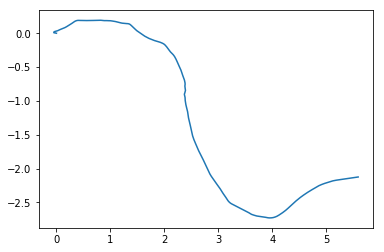

In [117]:
plt.plot(posx, posy)

In [118]:
abs_data = pd.DataFrame(columns='dt ax ay az'.split(' '))

In [119]:
abs_data.head()

,dt,ax,ay,az


In [120]:
acc_vector = np.array(([ [0,0] ]))

In [121]:
for i in range(0, ax.shape[0]):
    #print(ax[i], ay[i])
    vector = np.array( ([ax[i]] , [ay[i]] ))
    rotate_matrix = np.array (( [math.cos(-angle[i]), -math.sin(-angle[i])],
                                [math.sin(-angle[i]),  math.cos(-angle[i])] ))
    aceleration = rotate_matrix @ vector
    acc_vector = np.concatenate((acc_vector, aceleration.T), axis=0)

In [122]:
abs_data.ax = acc_vector[1:,0]
abs_data.ay = acc_vector[1:,1]
abs_data.dt = dt

In [123]:
abs_data.head()

,dt,ax,ay,az
0,682533.15002,-0.092000,0.032000,NaN
1,682533.16002,-0.065051,0.016805,NaN
2,682533.17007,-0.083092,0.017573,NaN
3,682533.18001,-0.072129,0.017476,NaN
4,682533.19002,-0.069220,0.025409,NaN


In [124]:
acc = 'ax ay az'.split(' ')
vel = 'vx vy vz'.split(' ')
pos = 'px py pz'.split(' ')

for i in range(0,3):
    
    abs_data[vel[i]] = first_integrate(dt, np.array(abs_data[acc[i]]), error_mean[acc[i]])
    abs_data[pos[i]] = second_integrate(dt, np.array(abs_data[vel[i]]))

In [125]:
abs_data.head()

,dt,ax,ay,az,vx,px,vy,py,vz,pz
0,682533.15002,-0.092000,0.032000,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,682533.16002,-0.065051,0.016805,NaN,-0.001004,0.000000,0.000187,0.000000,NaN,0.0
2,682533.17007,-0.083092,0.017573,NaN,-0.001968,-0.000015,0.000302,0.000002,NaN,NaN
3,682533.18001,-0.072129,0.017476,NaN,-0.002956,-0.000039,0.000419,0.000006,NaN,NaN
4,682533.19002,-0.069220,0.025409,NaN,-0.003882,-0.000074,0.000576,0.000011,NaN,NaN


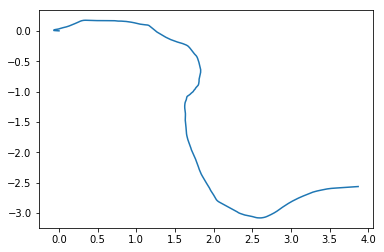

In [126]:
plt.plot(abs_data.px, abs_data.py)